# TEXT MINING - SIMILAR TEXT GROUPING

* Script developed using: R version 3.4.0 (2017-04-21)

* Platform: x86_64-w64-mingw32/x64 (64-bit)

* IBM - May 2018 (isabelad@br.ibm.com)

This notebook uses K-means clustering and t-SNE dimension reduction to support grouping analysis of sample questions to be used to create intentions for Watson Assistant (formely Watson Conversation).

In [1]:
#Libraries

library('dplyr') #data manipulation (filter, group, sort)
library('tidyr') #data tidying
library('ggplot2') #creating graphics
library('tm') #text mining
library('textstem') #stem and lemmatize text
library('ptstem') #stemming algorithms for the Portuguese Language
library('SnowballC') #text stemming
library('stringr') #string manipulation
library('wordcloud') # word-cloud generator
library('RColorBrewer') #color palettes
library('Rtsne') #R wrapper around the fast T-distributed Stochastic Neighbor Embedding implementation by Van der Maaten
library('dbscan') #density-based algorithms for spatial data (e.j.: OPTICS)
library('scatterplot3d') #three dimensional (3D) point cloud ploting

Warning message:
"package 'dplyr' was built under R version 3.4.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyr' was built under R version 3.4.3"Warning message:
"package 'ggplot2' was built under R version 3.4.3"Warning message:
"package 'tm' was built under R version 3.4.4"Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate

Warning message:
"package 'textstem' was built under R version 3.4.4"Warning message:
"package 'ptstem' was built under R version 3.4.4"Warning message:
"package 'wordcloud' was built under R version 3.4.4"Loading required package: RColorBrewer
Warning message:
"package 'Rtsne' was built under R version 3.4.4"Warning message:
"package 'dbscan' was built under R version 3.4.4"Warning message:
"package 'scatter

In [7]:
#Parameters

dir_file <- 'C:/Users/IsabelaDellaliberaPi/Box Sync/Backup Isa/CBDS/SANTANDER/Sara 2.0/Base Conhecimento/Cluster Workspaces/Perguntas'
base_file <- 'Perguntas Exemplo - Cartões  - Consolidado.csv'
token_file <- 'token.txt'
final_file <- 'cluster_perguntas.csv'
model_file <- 'model_perguntas.rda'
ngram <- 1
sparsity <- 0.995

## SECTION 1: Load and clean data

In [8]:
setwd(dir_file)
df <- read.csv(file = base_file, header = TRUE, sep = ";", dec = ".", stringsAsFactors = FALSE)
df <- cbind(df, ID=row.names(df))
head(df, 10)

Curador,Status,Data,Perguntas,ID
Deborah,Backlog,09/04/2018,segunda via de senha cartão debito,1
Deborah,Backlog,06/04/2018,estorno de anuidade para cartao cancelado,2
Deborah,Backlog,09/04/2018,quais são os cartões para pj,3
Nelson,Backlog,03/04/2018,qual cartão tem sala vip,4
Deborah,Backlog,09/04/2018,prazo de entrega cartão de crédito,5
Deborah,Backlog,11/04/2018,solicitação de um novo cartão expresso,6
Deborah,Backlog,11/04/2018,desbloquear cartão com erro de leitura,7
Deborah,Backlog,11/04/2018,limite diario compra cartao de debito,8
Nelson,Backlog,04/04/2018,erro na impressao de fatura,9
Deborah,Backlog,,inclusão debio automatico cartão de credito,10


In [9]:
#We are interested in the column containing the questions samples (e.j.:Perguntas)
df<- df[,4:5]
df_original <- df
df <- df[!duplicated(df$Perguntas),]

In [10]:
#Function for text normalization

unwanted_array = list(    'Š'='S', 'š'='s', 'Ž'='Z', 'ž'='z', 'À'='A', 'Á'='A', 'Â'='A', 'Ã'='A', 'Ä'='A', 'Å'='A', 'Æ'='A', 'Ç'='C', 'È'='E', 'É'='E',
                            'Ê'='E', 'Ë'='E', 'Ì'='I', 'Í'='I', 'Î'='I', 'Ï'='I', 'Ñ'='N', 'Ò'='O', 'Ó'='O', 'Ô'='O', 'Õ'='O', 'Ö'='O', 'Ø'='O', 'Ù'='U',
                            'Ú'='U', 'Û'='U', 'Ü'='U', 'Ý'='Y', 'Þ'='B', 'ß'='Ss', 'à'='a', 'á'='a', 'â'='a', 'ã'='a', 'ä'='a', 'å'='a', 'æ'='a', 'ç'='c',
                            'è'='e', 'é'='e', 'ê'='e', 'ë'='e', 'ì'='i', 'í'='i', 'î'='i', 'ï'='i', 'ð'='o', 'ñ'='n', 'ò'='o', 'ó'='o', 'ô'='o', 'õ'='o',
                            'ö'='o', 'ø'='o', 'ù'='u', 'ú'='u', 'û'='u', 'ý'='y', 'ý'='y', 'þ'='b', 'ÿ'='y' )

normalize_str <- function(s) {
  s <- iconv(s, from='UTF-8', to='ASCII//TRANSLIT')
  s <- chartr(paste(names(unwanted_array), collapse=''), paste(unwanted_array, collapse=''),s)
  s <- tolower(s)
  s <- gsub('/',' ', s)
  s<- removePunctuation(s)
  s <- removeNumbers(s)
    

#Dictionary with some important business specific terms to replace, mainly terms with less than 2 characters
###
  s <- gsub(' pj ',' pessoa juridica ', s)
  s <- gsub(' pf ',' pessoa fisica ', s)
  s <- gsub(' cc ',' conta corrente ', s)
  s <- gsub(' ag ',' agencia ', s)
  s <- gsub(' caps ',' capitalizacao ', s)
  s <- gsub(' cap ',' capitalizacao ', s)
  s <- gsub(' ib ',' internet banking ', s)
  s <- gsub(' ly ',' renly ', s)
  s <- gsub(' oy ',' renoy ', s)
  s <- gsub(' on line ',' online ', s)
  s <- gsub(' conta poupanca ',' contapoupanca ', s)
  s <- gsub(' conta max ',' contamax ', s)
  s <- gsub(' fundos ',' fundo ', s)
  s <- gsub(' di ',' cdi ', s)
  s <- gsub(' investimentos ',' investimento ', s)
  s <- gsub(' rendimentos ',' rendimento ', s)
  s <- gsub(' ir ',' imposto de renda ', s)
###
    
  s <- gsub('\\b\\w{1,2}\\b','', s)
  s <- removeWords(s, stopwords('portuguese'))
  s <- gsub('\\\n','', s)
  s <- gsub('\\ +',' ', s)
}

In [11]:
df$Perguntas <- normalize_str(df$Perguntas)
corpus <- normalize_str(df$Perguntas)
corpus <- ptstem(corpus, algorithm = "hunspell", complete = FALSE) #stemming algorithm for Portuguese
wc_corpus <- VCorpus(VectorSource(corpus), readerControl = list(language = "pt-BR"))

Warning message:
"package 'bindrcpp' was built under R version 3.4.4"

## SECTION 2: Create Term-Document Matrix for Text Mining

In [12]:
#Function for Tokenization

NgramTokenizer <- function(x){
  unlist(lapply(ngrams(words(x), c(1:ngram)), paste, collapse = ' '), use.names = FALSE)
  }


ndocs <- length(corpus)
MinTermFreq <- ndocs * 0.01 # ignore extremely rare words i.e. terms that appear in less then 1% of the documents
MaxTermFreq <- ndocs * .8 # ignore overly common words i.e. terms that appear in more than 80% of the documents


#Function to create the Document Term Matrix (dtm) by term frequency (tf-idf)

dtm <- TermDocumentMatrix(wc_corpus, 
                          control = list( weighting = function(x) weightTfIdf(x, normalize=FALSE),
                                          tokenize = NgramTokenizer,
                                          minWordLength = 2,
                                          bounds = list(global = c(MinTermFreq, MaxTermFreq)))
)

In [13]:
dtm <- removeSparseTerms(dtm, sparsity)


#Matrix with tokens to build the word cloud 
mtx <- dtm
mtx <- as.matrix(mtx)

#Matrix with each line representing one document and tokens in columns
dtm <- t(dtm)
dtm <- as.matrix(dtm)
# normalizing lines
norm_vec <- function(x) sqrt(sum(x^2))
norms <- apply(dtm, 1, norm_vec)
dtm <- dtm/norms
    
head(dtm, 10)

,adicional,alteracao,alterar,anuidade,automatico,black,bloquear,cadastrar,cancelar,cartao,...,taxar,titular,transformacao,unique,valor,vencer,vip,vir,visar,way
1,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.06225351,...,0,0,0,0,0,0,0.0000000,0.5867378,0,0
2,0,0,0,0.4313466,0.0000000,0,0.0000000,0,0.5424768,0.08296225,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
3,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.00000000,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
4,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.06851604,...,0,0,0,0,0,0,0.6818192,0.0000000,0,0
5,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.10342191,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
6,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.09998647,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
7,0,0,0,0.0000000,0.0000000,0,0.5446733,0,0.0000000,0.08848482,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
8,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.07513728,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
9,0,0,0,0.0000000,0.0000000,0,0.0000000,0,0.0000000,0.00000000,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
10,0,0,0,0.0000000,0.8584957,0,0.0000000,0,0.0000000,0.09544153,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0


In [14]:
# removing documents containing NA
dtm_na <- dtm[!duplicated(dtm),]
is_na <- rowSums(is.na(dtm_na)) == 0
dtm_na <- dtm_na[is_na,]

## Section 3: Wordcloud

,word,freq
debitar,debitar,109.36436
cartao,cartao,108.88784
anuidade,anuidade,98.59774
creditar,creditar,93.65497
limitar,limitar,88.06260
bloquear,bloquear,79.07623
sacar,sacar,76.79071
cartoes,cartoes,72.95117
faturar,faturar,72.95117
cancelar,cancelar,68.00000


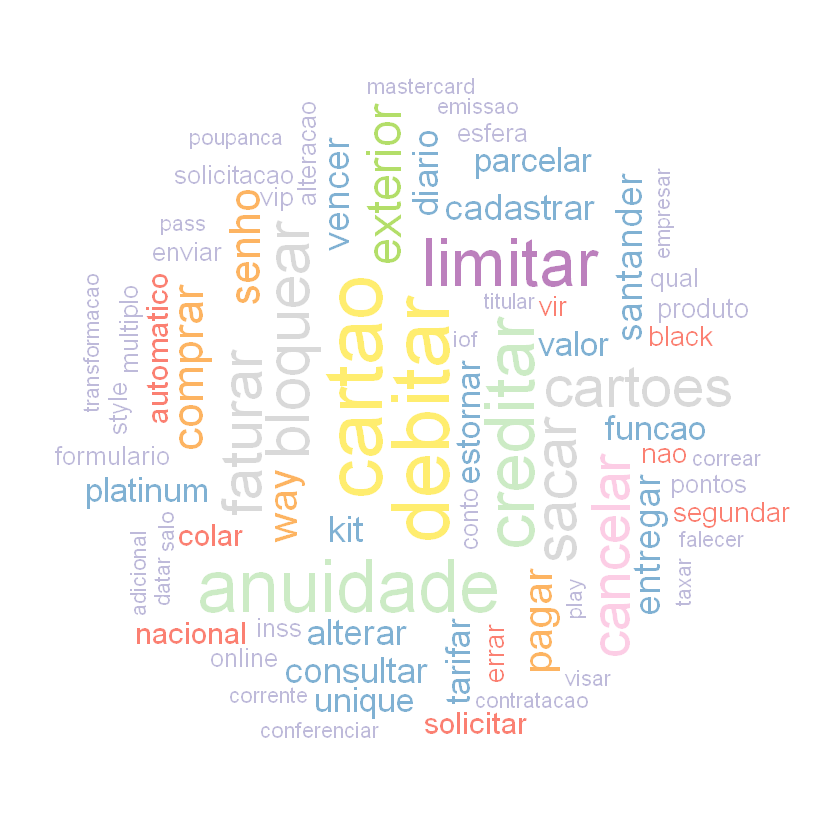

In [15]:
v <- sort(rowSums(mtx),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)
head(d, 10)
set.seed(1234)
wordcloud(words = d$word, freq = d$freq, min.freq = 1,
          max.words=100, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(12, "Set3"))

## Section 4: Using t-SNE

* t-distributed stochastic neighbor embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton.

* It is a non-linear dimensionality reduction technique that makes it easier complex data visualization.

* We will use this method for two dimensions.


In [16]:
# we will repeat the method a few times and pick up the one with the minor KL divergence
KL_val <- 99999999
for (i in 1:10) {
  
  #calculates a temporary t-SNE setting
  tsne_temp <- Rtsne(dtm_na, theta=0.0, max_iter=3000, pca_dims=100, perplexity=30, dims=2)
  
  # if KL divergence adjustment is less than the previous one, it updates
  if ( tail(tsne_temp$itercosts,1) < KL_val )
    tsne_out <- tsne_temp
  KL_val <- tail(tsne_temp$itercosts,1)
      
  print(tail(tsne_temp$itercosts,1))
}

[1] 0.4537013
[1] 0.4381996
[1] 0.4332038
[1] 0.4168195
[1] 0.4638796
[1] 0.4368605
[1] 0.4300875
[1] 0.4338392
[1] 0.4356273
[1] 0.4479224


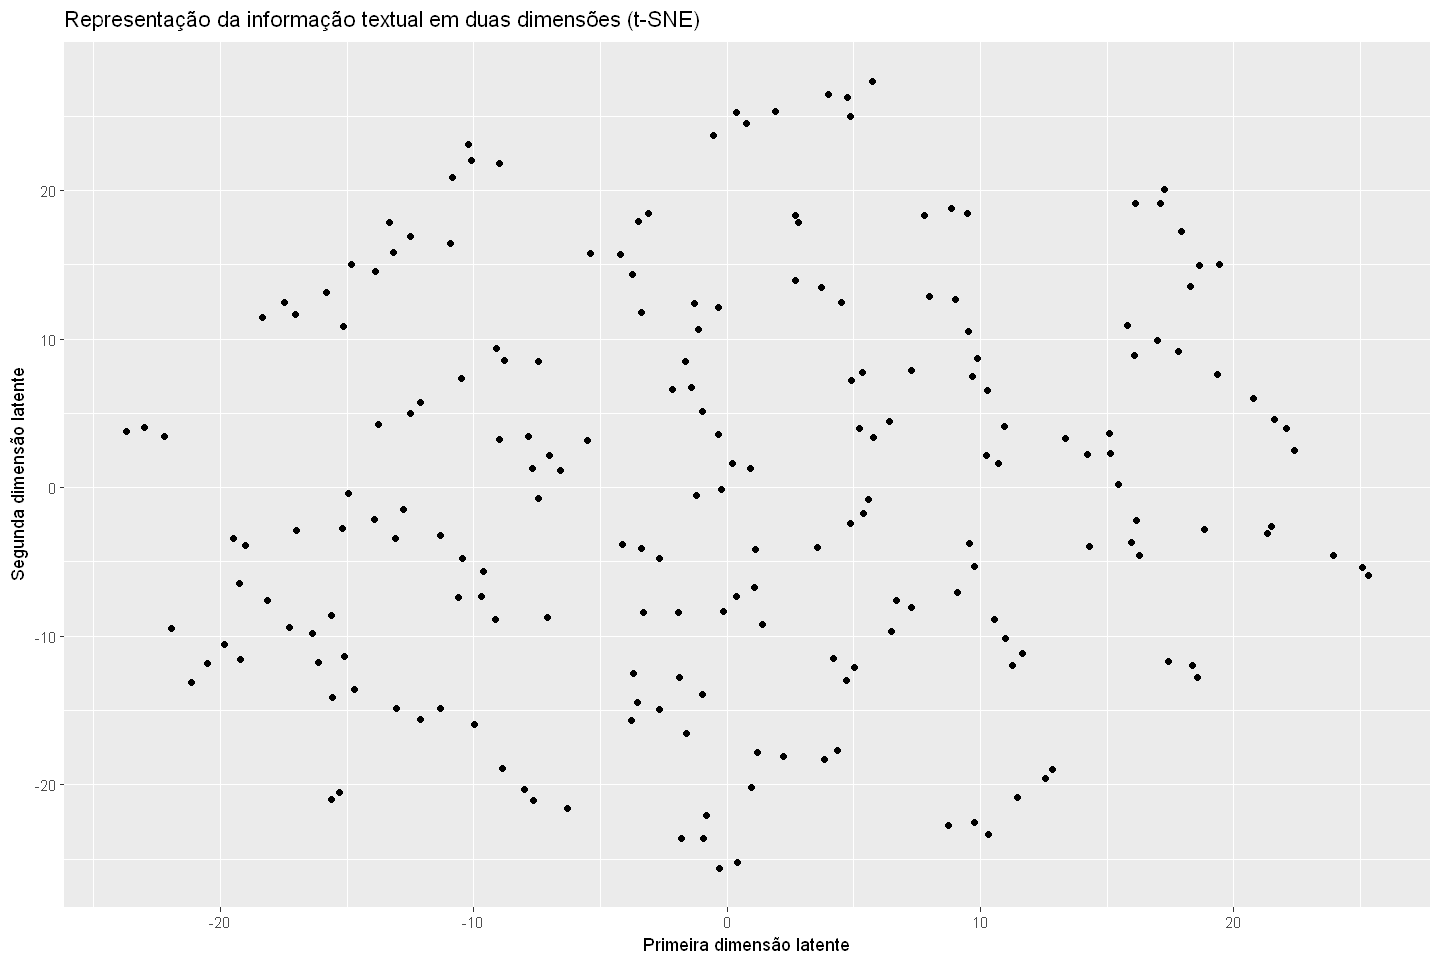

In [17]:
#plotting t-SNE result
options(repr.plot.width=12, repr.plot.height=8)

qplot(tsne_out$Y[,1], tsne_out$Y[,2], 
      main='Representação da informação textual em duas dimensões (t-SNE)',
      xlab='Primeira dimensão latente', ylab='Segunda dimensão latente')


## Section 5: Clustering using K-means algorithm

In [34]:
# dataframe with t-SNE result and document metadata [tf-idf]
tsne_df <- data.frame(ID = rownames(dtm_na),
                      y1 = tsne_out$Y[,1], 
                      y2 = tsne_out$Y[,2])
head(tsne_df,5)

ID,y1,y2
1,20.784155,5.972537
2,16.153662,-2.213497
3,7.976634,12.856253
4,5.236283,3.997564
5,-13.342668,17.880299


In [35]:
#Preparing dataset 

dtm_kmeans <- dtm
dtm_kmeans<- cbind.data.frame(Perguntas=df_original$Perguntas,dtm_kmeans)
dtm_kmeans<- cbind.data.frame(ID=df_original$ID,dtm_kmeans)
dtm_kmeans <- na.exclude(dtm_kmeans)
ID <- dtm_kmeans$ID  %>% as.data.frame()
colnames(ID) <- 'ID'
Perguntas <- dtm_kmeans$Perguntas %>% as.data.frame()
colnames(Perguntas) <- 'Perguntas'
dtm_kmeans <- dtm_kmeans[,-1:-2]
head(dtm_kmeans, 5)

adicional,alteracao,alterar,anuidade,automatico,black,bloquear,cadastrar,cancelar,cartao,...,taxar,titular,transformacao,unique,valor,vencer,vip,vir,visar,way
0,0,0,0.0000000,0,0,0,0,0.0000000,0.06225351,...,0,0,0,0,0,0,0.0000000,0.5867378,0,0
0,0,0,0.4313466,0,0,0,0,0.5424768,0.08296225,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
0,0,0,0.0000000,0,0,0,0,0.0000000,0.00000000,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0
0,0,0,0.0000000,0,0,0,0,0.0000000,0.06851604,...,0,0,0,0,0,0,0.6818192,0.0000000,0,0
0,0,0,0.0000000,0,0,0,0,0.0000000,0.10342191,...,0,0,0,0,0,0,0.0000000,0.0000000,0,0


In [36]:
#Prediction using K-means with k number of clusters
set.seed(5)
k <- 40

cl <- kmeans(dtm_kmeans, k, iter.max = 10, nstart = 1,
             algorithm = c("Hartigan-Wong", "Lloyd", "Forgy","MacQueen"), trace=FALSE)


In [37]:
clusters <- as.vector(cl$cluster)

dtm_kmeans<- cbind.data.frame(Perguntas=Perguntas,dtm_kmeans)
dtm_kmeans<- cbind.data.frame(Cluster=as.vector(cl$cluster),dtm_kmeans)
dtm_kmeans<- cbind.data.frame(ID=ID,dtm_kmeans)


tsne_df <- cbind(tsne_df, dtm_na)
tsne_df <- tsne_df[,-1]

#dim(dtm_cont[!duplicated(dtm_kmeans),])

dtm_kmeans <- dtm_kmeans[!duplicated(dtm_kmeans$Perguntas),]

#creating the final dataset with kmeans clustering results
merged_tsne <- merge(tsne_df, dtm_kmeans)

head(merged_tsne, 5)

adicional,alteracao,alterar,anuidade,automatico,black,bloquear,cadastrar,cancelar,cartao,...,vencer,vip,vir,visar,way,y1,y2,ID,Cluster,Perguntas
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9.86459,8.684156,177,9,conversão super bonus unique
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,21.49908,-2.616946,63,11,como solicitar nova chave de seguranca?
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16.99379,9.924998,155,33,boomerang de premios santander
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-11.32794,-3.229249,222,31,saque em moeda estrangeira
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-11.32794,-3.229249,218,31,saque saque moeda estrangeira


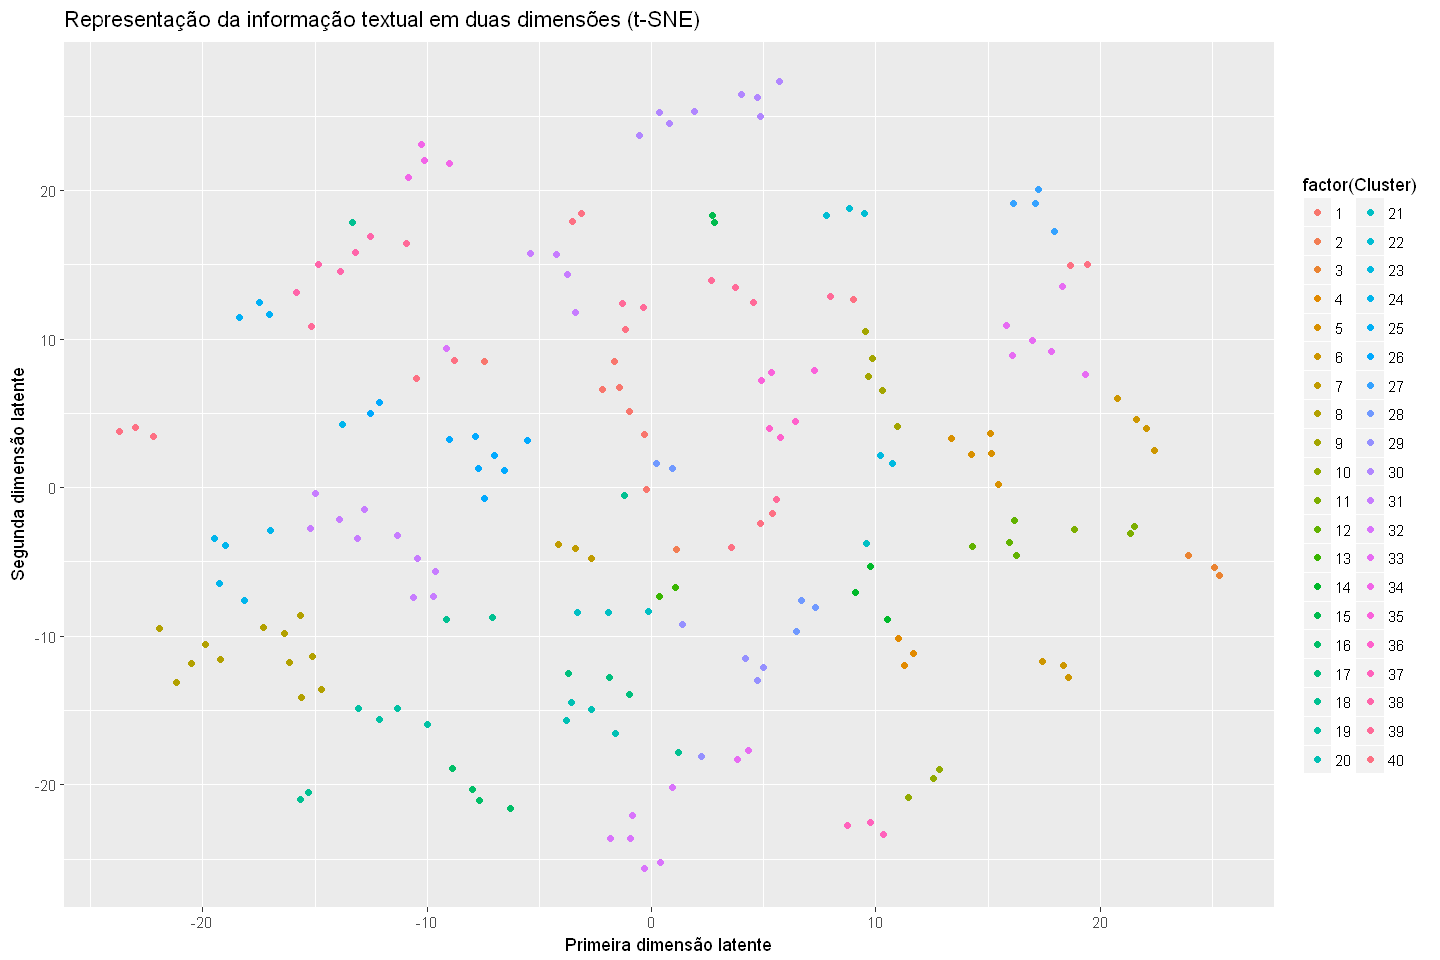

In [38]:
#plotting t-SNE result with clusters colors
options(repr.plot.width=12, repr.plot.height=8)

# dimensões latentes com resultado da clusterização pelo OPTICS
merged_tsne %>% 
  #filter(cluster == 4) %>%
  ggplot(aes(x=y1,y=y2,color=factor(Cluster))) + 
  geom_point() + 
  ggtitle('Representação da informação textual em duas dimensões (t-SNE)') +
  xlab('Primeira dimensão latente') + ylab('Segunda dimensão latente')

In [40]:
#Create final dataset with original questions sample and the cluster obtained using K-means
dtm_kmeans <- dtm_kmeans[, 1:3]

head(dtm_kmeans, 10)

ID,Cluster,Perguntas
1,6,segunda via de senha cartão debito
2,12,estorno de anuidade para cartao cancelado
3,39,quais são os cartões para pj
4,36,qual cartão tem sala vip
5,18,prazo de entrega cartão de crédito
6,10,solicitação de um novo cartão expresso
7,37,desbloquear cartão com erro de leitura
8,8,limite diario compra cartao de debito
9,37,erro na impressao de fatura
10,18,inclusão debio automatico cartão de credito


In [41]:
#Export Final Model
write.csv2(x = dtm_kmeans, file = 'cluster_cartoes_k40.csv', row.names = FALSE)

Final observations:

* This notebook does not contain an automatic definition for optimum number of clusters to be used for K-means classification algorithm.
* You can change the number of clusters predefined for K-means (k parameter) and then run the entire Section 5 again to analyze results plotted using cluster collors.